# Example usage of `resultdf()`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit, Gate
import qiskit.compiler
import qiskit.pulse as qpulse

from qiskit_tricks import resultdf

## Rabi experiment example

In [2]:
from qiskit.providers.aer import PulseSimulator
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

armonk = FakeArmonk()
pulse_simulator = PulseSimulator(
    armonk.configuration(),
    armonk.properties(),
    armonk.defaults(),
)

### Create the circuits

In [3]:
amps = np.linspace(-1.0, 1.0)
circuits = []

for amp in amps:
    circ = QuantumCircuit(1, 1)
    
    # Metadata fields will appear as additional levels in the dataframe index.
    circ.metadata = {
        'amp': amp,
        'duration': 320,
    }
    
    gate = Gate('Rabi', 1, [amp])
    circ.append(gate, [0])
    circ.measure(0, 0)
    
    with qpulse.build(pulse_simulator) as sched:
        qpulse.play(qpulse.Gaussian(320, amp, 80), qpulse.DriveChannel(0))
    
    circ.add_calibration(gate, [0], sched, [amp])
    
    circuits.append(circ)

circuits[0].draw()

┌──────────┐┌─┐
  q: ┤ Rabi(-1) ├┤M├
     └──────────┘└╥┘
c: 1/═════════════╩═
                  0

### Run the circuits

In [4]:
rabi_job = pulse_simulator.run(circuits)

### `resultdf()` with default arguments.

In [5]:
resultdf(rabi_job.result()).head()

count
job_id                               amp       duration state       
3139a371-6940-48c7-9545-cb15df8a5a6a -1.000000 320      0        371
                                                        1        653
                                     -0.959184 320      0        292
                                                        1        732
                                     -0.918367 320      0        201

The job id and circuit metadata (here 'duration' and 'amp') are stored in the dataframe's index. The classified states are stored in the 'state' index level. The 'count' column stores the counts for each state.

### You can also pass `Job` objects directly.

In [6]:
resultdf(rabi_job).head()

count
job_id                               amp       duration state       
3139a371-6940-48c7-9545-cb15df8a5a6a -1.000000 320      0        371
                                                        1        653
                                     -0.959184 320      0        292
                                                        1        732
                                     -0.918367 320      0        201

### `metadata` parameter

By default, `resultdf()` automatically determines the metadata to include in the index.
Pass `metadata=[...]` to manually specify the relevant fields e.g. just 'amp':

In [7]:
resultdf(rabi_job, metadata=['amp']).head()

count
job_id                               amp       state       
3139a371-6940-48c7-9545-cb15df8a5a6a -1.000000 0        371
                                               1        653
                                     -0.959184 0        292
                                               1        732
                                     -0.918367 0        201

or pass `metadata=False` to ignore metadata

In [8]:
resultdf(rabi_job, metadata=False).head()

count
job_id                               circuit   state       
3139a371-6940-48c7-9545-cb15df8a5a6a circuit-2 0        371
                                               1        653
                                     circuit-3 0        292
                                               1        732
                                     circuit-4 0        201

### `drop_extraneous` parameter
By default, `resultdf()` will drop useless columns and levels. For example, passing `drop_extraneous=False` in this instance gives

In [9]:
resultdf(rabi_job, drop_extraneous=False).head()

count  \
job_id                               circuit   amp       duration state          
3139a371-6940-48c7-9545-cb15df8a5a6a circuit-2 -1.000000 320      0        371   
                                                                  1        653   
                                     circuit-3 -0.959184 320      0        292   
                                                                  1        732   
                                     circuit-4 -0.918367 320      0        201   

                                                                         c  
job_id                               circuit   amp       duration state     
3139a371-6940-48c7-9545-cb15df8a5a6a circuit-2 -1.000000 320      0      0  
                                                                  1      1  
                                     circuit-3 -0.959184 320      0      0  
                                                                  1      1  
                                     circuit-4 -0.918367 320      0      0

The level 'circuit' and column 'c' were dropped.
The 'circuit' level is extraneous because each circuit is already uniquely identified by an 'amp'.
The 'c' column (representing the value of the 'c' register) is dropped because there is only one register.
The register columns are useful when there are multiple registers (see next example).

### Accessing the original result object
The original results are stored in the data set's `attrs` dictionary. This is where pandas allows users to store arbitrary data.

In [10]:
orig_results = resultdf(rabi_job).attrs['results']
print(repr(orig_results)[:100] + '...')

[Result(backend_name='fake_armonk', backend_version='2.4.3', qobj_id='3ce5f57b-f393-44e6-a479-6cf196...


### Plot the results

<AxesSubplot:xlabel='amp [a.u.]', ylabel='$|0\\rangle$ population'>

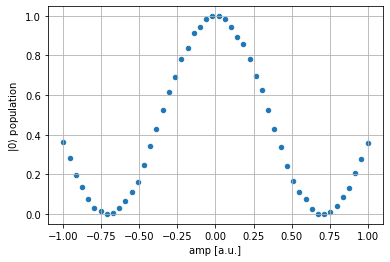

In [11]:
df = resultdf(rabi_job)

# Get a cross-section of only the 0 state.
data = df.xs(0, level='state')

# pandas wrangling.
data = data.reset_index()
data['pop'] = data['count']/1024

data.plot(
    x='amp',
    y='pop',
    kind='scatter',
    xlabel='amp [a.u.]',
    ylabel=r'$|0\rangle$ population',
    grid=True,
)

## GHZ example

In [12]:
from qiskit import Aer
simulator = Aer.get_backend('aer_simulator')

### Create the circuit

In [13]:
q1 = QuantumRegister(1)
q2 = QuantumRegister(2)
c1 = ClassicalRegister(1, 'c1')
c2 = ClassicalRegister(2, 'c2')

bell = QuantumCircuit(q1, q2, c1, c2)
bell.h(q1)
bell.cx(q1, q2)

bell.measure(q1, c1)
bell.measure(q2, c2)

simulator = Aer.get_backend('aer_simulator')
bell = qiskit.compiler.transpile(bell, simulator)

### Run the circuit

In [14]:
ghz_job = simulator.run(bell)
df = resultdf(ghz_job)
df

count  c1  c2
job_id                               state               
418cd678-5dc1-4b97-8bbf-ebc577303c93 0        500   0   0
                                     7        524   1   3

### Post select on register c1

In [15]:
df.query('c1 == 0')

,,count,c1,c2
job_id,state,,,
418cd678-5dc1-4b97-8bbf-ebc577303c93,0,500,0,0


In [16]:
df.query('c1 == 1')

,,count,c1,c2
job_id,state,,,
418cd678-5dc1-4b97-8bbf-ebc577303c93,7,524,1,3


### Concatenate multiple jobs

In [17]:
# Run another GHZ circuit.
ghz_job2 = simulator.run(bell)
df = resultdf(ghz_job, ghz_job2)
df

count  c1  c2
job_id                               state               
418cd678-5dc1-4b97-8bbf-ebc577303c93 0        500   0   0
                                     7        524   1   3
66d1a0bf-0c77-47fb-a482-17ab81e672b3 7        526   1   3
                                     0        498   0   0

In [18]:
df2 = df.droplevel('job_id')
df2 = df2.groupby(df2.index).sum()
df2

,count,c1,c2
state,,,
0,998,0,0
7,1050,2,6


## MeasLevel.KERNELED example
The examples so far have dealt with classified measurements. The following gives a `resultdf()` example with kerneled data.

In [19]:
import uuid
from qiskit.result import Result

# Create a fake Result object containing single-shot kerneled data.
# The result is meant to represent measuring all 5 qubits in the |0> state.
result = Result.from_dict({
    'backend_name': 'acme_lumbridge',
    'backend_version': '0.0.1',
    'qobj_id': str(uuid.uuid4()),
    'job_id': '123456789abcdef',
    'success': True,
    'results': [
        {
            'header': {
                'name': 'circuit-1',
                'metadata': {'fizz': 10, 'buzz': 20},
                'memory_slots': 5,
                'creg_sizes': [
                    ['c0', 3],
                    ['c1', 2],
                ],
                'clbit_labels': (
                    [['c0', i] for i in range(3)]
                    + [['c1', i] for i in range(2)]
                ),
            },
            'shots': 1024,
            'success': True,
            'data': {
                # Fake (I,Q) data.
                'memory': np.random.normal(
                    [[-6.480142e+07, -1.572462e+08],
                     [-2.600460e+07, -6.162624e+07],
                     [-2.725883e+07, -7.046059e+07],
                     [-3.571589e+07, -6.477995e+07],
                     [-3.088182e+07, -1.017315e+08]],
                    [[9.558022e+06],
                     [1.167238e+07],
                     [1.303486e+07],
                     [1.332440e+07],
                     [9.971370e+06]],
                    size=(1024, 5, 2)
                ).tolist(),
            },
            'meas_level': 1,
            'meas_return': 'single',
            'status': 'DONE',
        }
    ],
    'date': '2022-01-01T10:10:00.000000',
    'status': 'Successful completion',
    'header': {},
})

In [20]:
resultdf(result)

job_id           shot  fizz  buzz  creg  bit
123456789abcdef  0     10    20    c0    0     -7.041622e+07-1.513835e+08j
                                         1     -4.846306e+07-6.425722e+07j
                                         2     -1.245725e+07-8.583532e+07j
                                   c1    0     -3.039003e+07-6.317987e+07j
                                         1     -2.953558e+07-1.185521e+08j
                                                           ...            
                 1023  10    20    c0    0     -5.908685e+07-1.482073e+08j
                                         1     -5.057869e+07-6.632916e+07j
                                         2     -4.225385e+07-7.193906e+07j
                                   c1    0     -2.732521e+07-8.576400e+07j
                                         1     -8.148955e+06-1.106506e+08j
Length: 5120, dtype: complex128

`resultdf()` returns a series for kerneled measurements. The complex values are the usual (I, Q) points (I is real and Q is imaginary).
The 'creg' and 'bit' levels indicate which register and bit the measurement belongs to.
The 'shot' level indicates on which shot the measurement was acquired. Measurements are acquired in time in ascending shot order.

### Average over shots
You would get the same series if the job was run with `meas_return='avg'`.

In [21]:
df = resultdf(result)
df.groupby(df.index.names.difference(['shot'])).mean()

job_id           fizz  buzz  creg  bit
123456789abcdef  10    20    c0    0     -6.500495e+07-1.565098e+08j
                                   1     -2.609155e+07-6.164900e+07j
                                   2     -2.735190e+07-7.018283e+07j
                             c1    0     -3.574615e+07-6.536866e+07j
                                   1     -3.062454e+07-1.020650e+08j
dtype: complex128

### Plot points for register c0

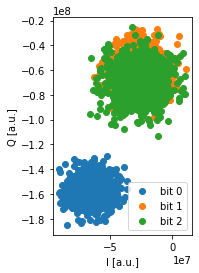

In [22]:
for i in range(3):
    df = resultdf(result)
    df = df.xs(('c0', i), level=('creg', 'bit'))
    plt.scatter(df.values.real, df.values.imag, label=f'bit {i}')

plt.gca().set_aspect(1.0)
plt.xlabel('I [a.u.]')
plt.ylabel('Q [a.u.]')
plt.legend()